In [9]:
import json
import xml.etree.ElementTree as ET
from torch._C import dtype
import xmltodict
import numpy as np
import torch
from torchvision.ops import box_iou
import os
from tqdm import tqdm

In [ ]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

%cd ../../

In [19]:
# def remove_cr(pred_row_list, img_height):
#     pred_row_list_copy = pred_row_list
#     for index, row in enumerate(pred_row_list):
#         if (row[3]-row[1])>(img_height/2):
#             del pred_row_list_copy[index]
#     return pred_row_list_copy

def check_missing_row(pred_rows_sorted, truth_rows_sorted, diff_threshold = 60):
    if len(pred_rows_sorted) == len(truth_rows_sorted):
        return None
    else:
        if abs(pred_rows_sorted[0][1] - truth_rows_sorted[0][1]) < diff_threshold:
            return None
        else:
            return 1

def get_missing_toprow_per_image(pred_file, truth_file):
    with open(pred_file) as f:
        pred_json = json.load(f)
    pred_rows = []
    for i in pred_json['row_boxes']:
        pred_rows.append([i['x1'], i['y1'], i['x2'], i['y2']])
    
    truth_rows = []
    tree = ET.parse(truth_file)
    xml_data = tree.getroot()
    #here you can change the encoding type to be able to set it to the one you need
    xmlstr = ET.tostring(xml_data, encoding='utf-8', method='xml')

    data_dict = dict(xmltodict.parse(xmlstr))
    for i in data_dict['annotation']['object']:
        if i['name'] in ['rack row', 'rack Row', 'Rack row', 'Rack Row']:
            truth_rows.append(list(i['bndbox'].values()))

    image_height = data_dict['annotation']['size']['height']

    # print("Total true boxes: ", len(truth_boxes))
    # print("Total predicted boxes: ", len(pred_boxes))

    pred_rows = np.array(pred_rows).astype('int')
    truth_rows = np.array(truth_rows).astype('int')
    
    pred_rows = torch.from_numpy(pred_rows).float()
    truth_rows = torch.from_numpy(truth_rows).float()

    pred_rows_sorted = sorted(pred_rows, key=lambda x: x[1])
    truth_rows_sorted = sorted(truth_rows, key=lambda x: x[1])

    #pred_rows_sorted_cleaned = remove_cr(pred_rows_sorted, image_height)

    missing_row = check_missing_row(pred_rows_sorted, truth_rows_sorted)

    return missing_row

In [34]:
def get_missing_toprow(pred_files_path, truth_files_path):

    missing_rows_all = []

    for i in tqdm(os.listdir(pred_files_path)):
        try:
            missing_row  = get_missing_toprow_per_image(pred_files_path+i, truth_files_path+i.split('.')[0]+'.xml')
            missing_rows_all.append(missing_row)
        except:
            continue
    return missing_rows_all

In [87]:
pred_file = '/media/premium/common-biscuit/main/planogram_biscuit/data/output/image_annotations/rackrow_detection/op_annotations/'
truth_file = '/media/premium/common-biscuit/main/planogram_biscuit/data/raw/annotations_master/'
missing_rows_all = get_missing_toprow(pred_file, truth_file)


100%|██████████| 157/157 [00:01<00:00, 108.86it/s]


In [88]:
from collections import Counter
missing_row_count = Counter(missing_rows_all)

In [89]:
missing_row_count_correct = {}
missing_row_count_correct['top_rows'] = missing_row_count[None]
missing_row_count_correct['missing_top_rows'] = missing_row_count[1] 

In [90]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

{'top_rows': 1565, 'missing_top_rows': 34}


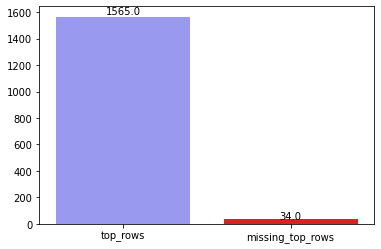

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
print(missing_row_count_correct)
clrs =['#8A8AFF', 'red']

keys = list( missing_row_count_correct.keys())
values = list(missing_row_count_correct.values())

p = sns.barplot(x=keys, y=values,palette=clrs)
show_values(p)

{'top_rows': 147, 'missing_top_rows': 10}


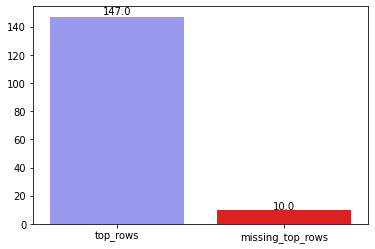

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
print(missing_row_count_correct)
clrs =['#8A8AFF', 'red']

keys = list( missing_row_count_correct.keys())
values = list(missing_row_count_correct.values())

p = sns.barplot(x=keys, y=values,palette=clrs)
show_values(p)